# Imports

In [99]:
import pandas             as pd
import numpy              as np
import seaborn            as sns
import inflection
import math
import datetime
import xgboost            as xgb
import random

from IPython.core.display  import HTML
from matplotlib            import pyplot     as plt
from matplotlib            import gridspec
from tabulate              import tabulate
from scipy                 import stats      as ss
from boruta                import BorutaPy

from sklearn               import preprocessing
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## Helper Functions

In [4]:
def personal_settings():
    
    # plotly settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
        
    # notebook settings
    display(HTML('<style>.container{width:90% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.2f}'.format)

        
    # seaborn settings
    sns.set(rc={'figure.figsize':(20,10)})
    sns.set_theme(style = 'darkgrid', font_scale = 1.5)
    
    # %matplotlib inline
    # %pylab inline
    # pd.options.display.max_columns = None
    # pd.options.display.max_rows = None
    # pd.set_option( 'display.expand_frame_repr', False )
    # pd.options.display.float_format = '{:,.2f}'.format
    # np.set_printoptions(suppress=True)
    
def cramer_v (x,y):
    cm = pd.crosstab(x,y).to_numpy() # contingency matriz
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    
    chi2corr = max (0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1);
    rcorr = r - (r-1)**2/(n-1);
    
    return np.sqrt( (chi2corr/n) / (min (kcorr-1, rcorr-1)) )

# ml_error function (7 Machine Learning Modeling)
def ml_error(model_name, y, yhat): # y: real values, yhat: predicted values
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rsme = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RSME': rsme}, index=[0])

# cross_validation (7.6 Model Comparison)
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list=[]
    mape_list=[]
    rmse_list=[]

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\n Kfold number: {}'.format(k))

        # start and end validation dates
        validation_start = x_training['date'].max() - datetime.timedelta(days=k*6*7) # six weeks times seven days
        validation_end = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7) # six weeks times seven days

        # filtering dataset
        training = x_training[x_training['date'] < validation_start] # x_training = X_train[cols_selected_boruta_full] // X_train = df6[df6['date'] < '2015-06-19'] // cols = seleced by boruta + dates + sales
        validation = x_training[ (x_training['date'] >= validation_start) & (x_training['date'] <= validation_end)]

        # training and validation dataset
        xtraining = training.drop(['date','sales'], axis=1) # training = x_training[x_training['date'] < validation_start] // x_training = X_train[cols_selected_boruta_full] // X_train = df6[df6['date'] < '2015-06-19'] // cols = seleced by boruta + dates + sales
        ytraining = training['sales']

        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = lr.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # performance storage
        mae_list.append(m_result['MAE']) 
        mape_list.append(m_result['MAPE']) 
        rmse_list.append(m_result['RSME']) 


    return pd.DataFrame(
                        {'Model Name': model_name,
                         'MAE Mean CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE Mean CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE Mean CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str) }, 
                        index=[0])

In [5]:
personal_settings();

## Loading Data

In [6]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

# merging datsets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# DATA DESCRIPTION

In [7]:
df1=df_raw.copy()

## Rename Columns

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']


# changing the name of the columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# renaming dataset columns
df1.columns = cols_new
print(df1.columns)

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')


## Data Dimension

In [10]:
print('Number of rows: {}' .format(df1.shape[0]))
print('Number of columns: {}' .format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## Data Types

In [11]:
print(df1.dtypes)
df1.head()

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


## Check NA 

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [13]:
# ======= competition_distance

#checking maximum value
df1['competition_distance'].max() # The maximum distance is:  75860.0

# replacing each NA
df1['competition_distance'] = df1['competition_distance'].apply(lambda x:2000000.0 if math.isnan(x) else (x))

In [14]:
df1['date'] = pd.to_datetime(df1['date'])

#  ======= competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#  ======= competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


In [15]:
# ======= promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# ======= promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


In [16]:
# ======= promo_interval

month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# filling Na with "0"
df1['promo_interval'].fillna(0, inplace=True)

# finding the month name given month number by mapping the "month_map" dictionary
df1 ['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0
                                                                  else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                                  else 0, axis=1 )

In [17]:
df1[['competition_distance','competition_open_since_month','competition_open_since_year',
     'promo2_since_week','promo2_since_year','promo_interval', 'month_map', 'is_promo']].sample(5)

,competition_distance,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
24997,5260.00,9.00,2012.00,28.00,2015.00,0,Jul,0
849983,4590.00,3.00,2000.00,40.00,2011.00,"Jan,Apr,Jul,Oct",May,0
4540,2370.00,3.00,2011.00,40.00,2014.00,"Jan,Apr,Jul,Oct",Jul,1
864630,3770.00,5.00,2013.00,20.00,2013.00,0,May,0
12943,4140.00,9.00,2012.00,30.00,2015.00,0,Jul,0


## Change Variable Types

In [18]:
print(df1.dtypes)
df1.sample()

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
496137,748,7,2014-04-13,0,0,0,0,0,0,d,a,2380.00,3.00,2010.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct",Apr,1


In [19]:
df1['date'].dtypes

dtype('<M8[ns]')

In [20]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

## Descriptive Statistical

In [21]:
num_df1 = df1.select_dtypes(include=['int64','float64'])
cat_df1 = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### Numerical Attributes

In [22]:
# central tendendy - mean, median
ct1 = pd.DataFrame(num_df1.apply(np.mean)).T
ct2 = pd.DataFrame(num_df1.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_df1.apply(np.std)).T
d2 = pd.DataFrame(num_df1.apply(min)).T
d3 = pd.DataFrame(num_df1.apply(max)).T
d4 = pd.DataFrame(num_df1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_df1.apply(lambda x: x.kurtosis)).T

# concatenate 
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,<bound method NDFrame._add_numeric_operations....
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,<bound method NDFrame._add_numeric_operations....
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,<bound method NDFrame._add_numeric_operations....
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,<bound method NDFrame._add_numeric_operations....
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,<bound method NDFrame._add_numeric_operations....
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,<bound method NDFrame._add_numeric_operations....
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,<bound method NDFrame._add_numeric_operations....
7,competition_distance,20.00,2000000.00,1999980.00,10610.59,2330.00,101810.65,19.38,<bound method NDFrame._add_numeric_operations....
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,<bound method NDFrame._add_numeric_operations....
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,<bound method NDFrame._add_numeric_operations....


### Categorical Attributes

In [23]:
cat_df1.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [24]:
# checking data interval
print(df1['date'].min(), '-> First Date')
print(df1['date'].max(), '-> Last Date')
df1['date'].dtypes

2013-01-01 00:00:00 -> First Date
2015-07-31 00:00:00 -> Last Date


dtype('<M8[ns]')

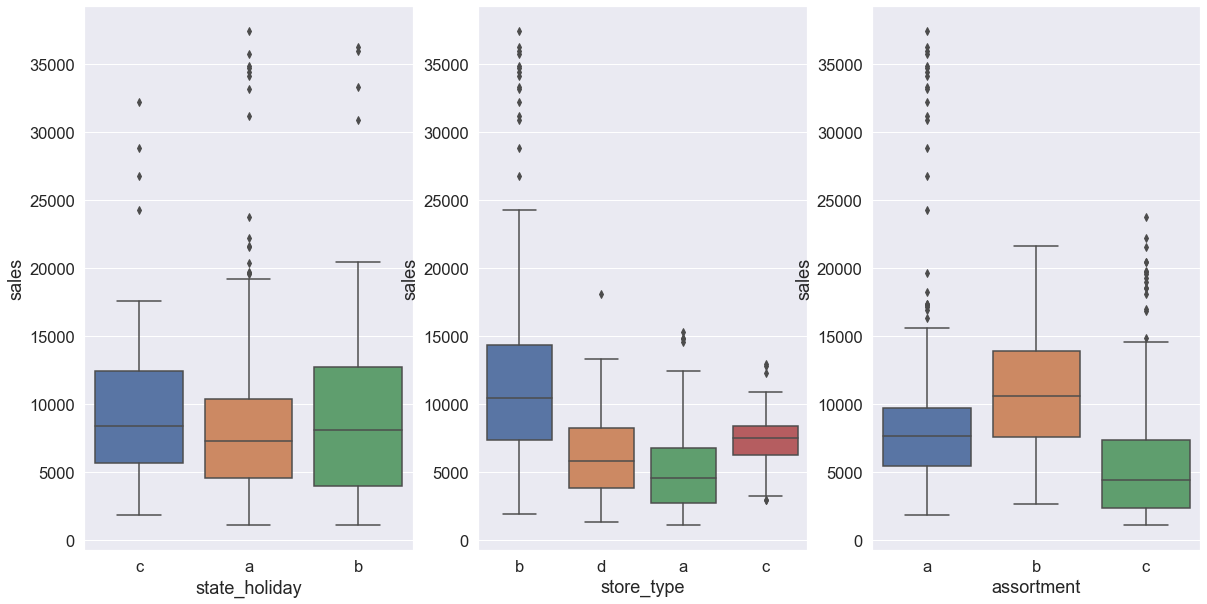

In [25]:
# filtering sales that happened during a state holiday
aux1 = df1[(df1['state_holiday']!='0') & (df1['sales']>0) & (df1['date']<'2015-01-01')]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1);


# <FONT COLOR='RED'> FEATURE ENGINEERING

In [26]:
df2=df1.copy()

## <font color=red> Mind Map Hypothesis 

In [27]:
# importing hipothesis mind map
# Image('img/MindMapHypothesis.png')

## Creating Hypothesis

### Store Hypothesis

1. Stores with bigger assortment should sell more.

2. Stores with closer competitors should sell less.

3. Stores with longer competitors should sell more. 

### Product Hypothesis

4. Stores with longer active promotions should sell more.

5. Stores with more promotion days should sell more.

### Periodicity Hypothesis

7. Stores open during Christmas holiday sHould sell more.

8. Stores should sell more over the years.

9. Stores should sell more in the second semester.

10. Stores should sell more after the 10th of each month.

11. Stores should sell less on weekends.

12. Stores should sell less during school holidays.

## Hypothesis Resume

1. Stores with bigger assortment should sell more.

2. Stores with closer competitors should sell less.

3. Stores with longer competitors should sell more. 

4. Stores with longer active promotions should sell more.

6. Stores with more consecutive promotions should sell more.

7. Stores open during Christmas holiday sHould sell more.

8. Stores should sell more over the years.

9. Stores should sell more in the second semester.

10. Stores should sell more after the 10th of each month.

11. Stores should sell less on weekends.

12. Stores should sell less during school holidays.

## Feature Engineering

In [28]:
df2 = df1.copy()
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4,2015,0,31,2015,0,Jul,0


In [29]:
# creating 'year' from 'date'
df2['year'] = df2['date'].dt.year

# creating 'month' from 'date'
df2['month'] = df2['date'].dt.month

# creating 'day' from 'date'
df2['day'] = df2['date'].dt.day

# creating 'week_of_year' from 'date'
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# creating 'year_week' from 'date'
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [30]:
print(df2[['date','year','month','day','week_of_year','year_week']].dtypes)
df2[['date','year','month','day','week_of_year','year_week']].head()

date            datetime64[ns]
year                     int64
month                    int64
day                      int64
week_of_year             int64
year_week               object
dtype: object


,date,year,month,day,week_of_year,year_week
0,2015-07-31,2015,7,31,31,2015-30
1,2015-07-31,2015,7,31,31,2015-30
2,2015-07-31,2015,7,31,31,2015-30
3,2015-07-31,2015,7,31,31,2015-30
4,2015-07-31,2015,7,31,31,2015-30


In [31]:
# creating 'competition_open_since' by combining 'competition_open_since_year and 'competition_open_since_month'
df2['competition_open_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

# creating 'competition_open_timeinmonths' by calculating the difference between 'date' and 'competition_open_since':
df2['competition_open_timeinmonths'] = ((df2['date']-df2['competition_open_since'])/30).apply(lambda x: x.days).astype('int64')

In [32]:
print(df2[['date','competition_open_since_year','competition_open_since_month',
           'competition_open_since','competition_open_timeinmonths']].dtypes)

df2[['date','competition_open_since_year','competition_open_since_month',
     'competition_open_since','competition_open_timeinmonths']].head()

date                             datetime64[ns]
competition_open_since_year               int64
competition_open_since_month              int64
competition_open_since           datetime64[ns]
competition_open_timeinmonths             int64
dtype: object


,date,competition_open_since_year,competition_open_since_month,competition_open_since,competition_open_timeinmonths
0,2015-07-31,2008,9,2008-09-01,84
1,2015-07-31,2007,11,2007-11-01,94
2,2015-07-31,2006,12,2006-12-01,105
3,2015-07-31,2009,9,2009-09-01,71
4,2015-07-31,2015,4,2015-04-01,4


In [33]:
# creating 'promo_since' by combining 'promo2_since_year' and 'promo2_since_week'
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) # string type (year-week, ex: 2015-31)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))  # date type (yyyy-mm-dd)

# creating 'promo_since_timeinweeks' by calculating the difference between 'date' and 'promo_since':
df2['promo_since_timeinweeks'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype(np.int64)

In [34]:
print(df2[['date','promo2_since_year','promo2_since_week','promo_since','promo_since_timeinweeks']].dtypes)

df2[['date','promo2_since_year','promo2_since_week','promo_since','promo_since_timeinweeks']].head()

date                       datetime64[ns]
promo2_since_year                   int64
promo2_since_week                   int64
promo_since                datetime64[ns]
promo_since_timeinweeks             int64
dtype: object


,date,promo2_since_year,promo2_since_week,promo_since,promo_since_timeinweeks
0,2015-07-31,2015,31,2015-07-27,0
1,2015-07-31,2010,13,2010-03-22,279
2,2015-07-31,2011,14,2011-03-28,226
3,2015-07-31,2015,31,2015-07-27,0
4,2015-07-31,2015,31,2015-07-27,0


In [35]:
# changing 'assortment' attribute by given classification
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' 
                                                 else 'extra' if x=='b' 
                                                 else 'extended')

In [36]:
print(df2[['assortment']].dtypes)

df2[['assortment']].head()

assortment    object
dtype: object


,assortment
0,basic
1,basic
2,basic
3,extended
4,basic


In [37]:
# changing 'sate_holiday' attribute by given classification
df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'Public holiday' if x=='a' 
                                                        else 'Easter holiday' if x=='b' 
                                                        else 'Christmas'      if x=='c'
                                                        else 'regular day')

In [38]:
print(df2[['state_holiday']].dtypes)

df2[['state_holiday']].head()

state_holiday    object
dtype: object


,state_holiday
0,regular day
1,regular day
2,regular day
3,regular day
4,regular day


# VARIABLE FILTERING

In [39]:
df3=df2.copy()

## Lines Filtering

In [40]:
# checking data interval
print(df3['date'].min(), '-> First Date')
print(df3['date'].max(), '-> Last Date')

2013-01-01 00:00:00 -> First Date
2015-07-31 00:00:00 -> Last Date


In [41]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

## Columns Selections

In [42]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [43]:
df3['date'].max()

Timestamp('2015-07-31 00:00:00')

In [44]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_open_since',
       'competition_open_timeinmonths', 'promo_since',
       'promo_since_timeinweeks'],
      dtype='object')

# <font color=red>EDA

In [45]:
df4=df3[df3['date']<'2015-01-01'].copy() # filtering year for better analysis

In [46]:
num_df4 = df4.select_dtypes(include=['int64','float64'])
cat_df4 = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## Univariate Analysis

### Response Variable

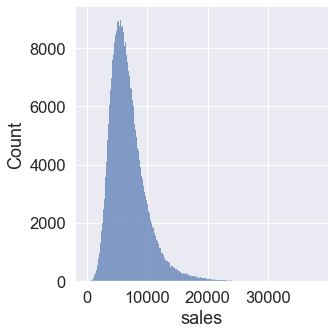

In [47]:
sns.displot(df4['sales'], legend=True, kde=False);

### Numerical Variables

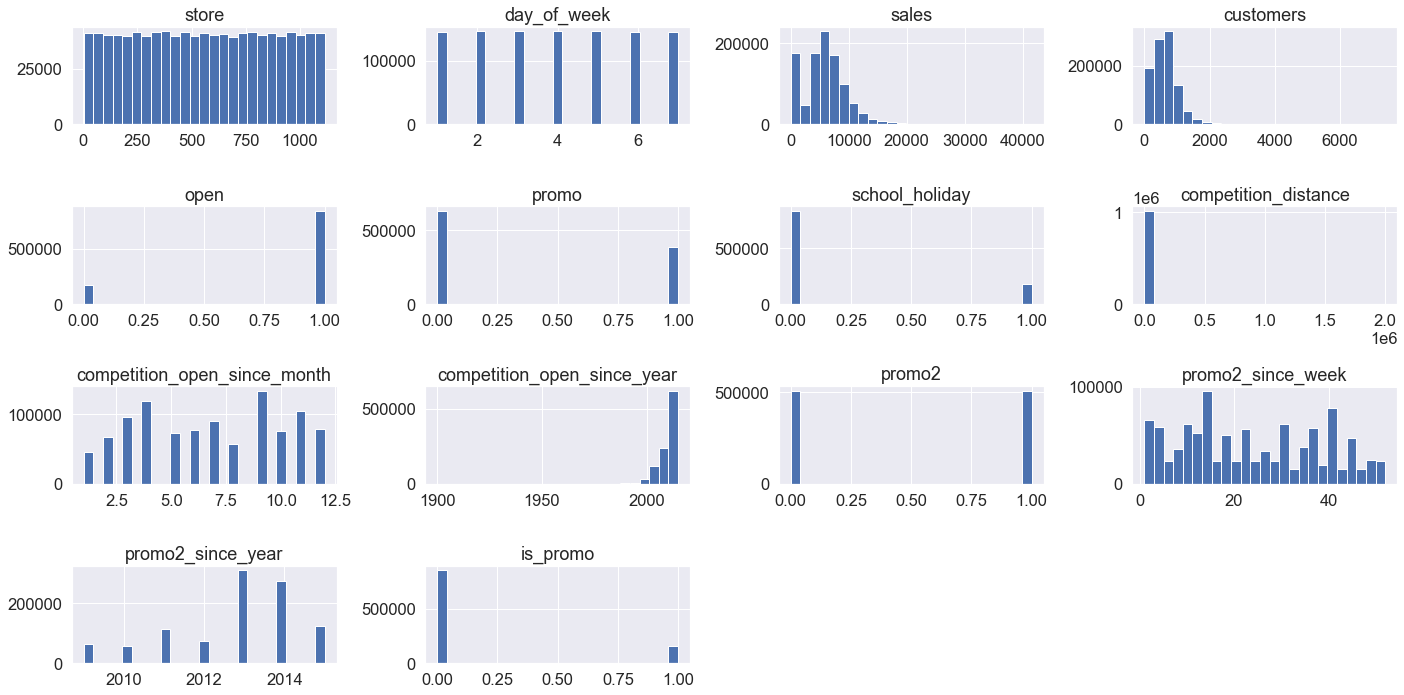

In [48]:
num_df1.hist(bins=25);
plt.tight_layout()

### <font color=red>Categorical Variables

In [49]:
cat_df1.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


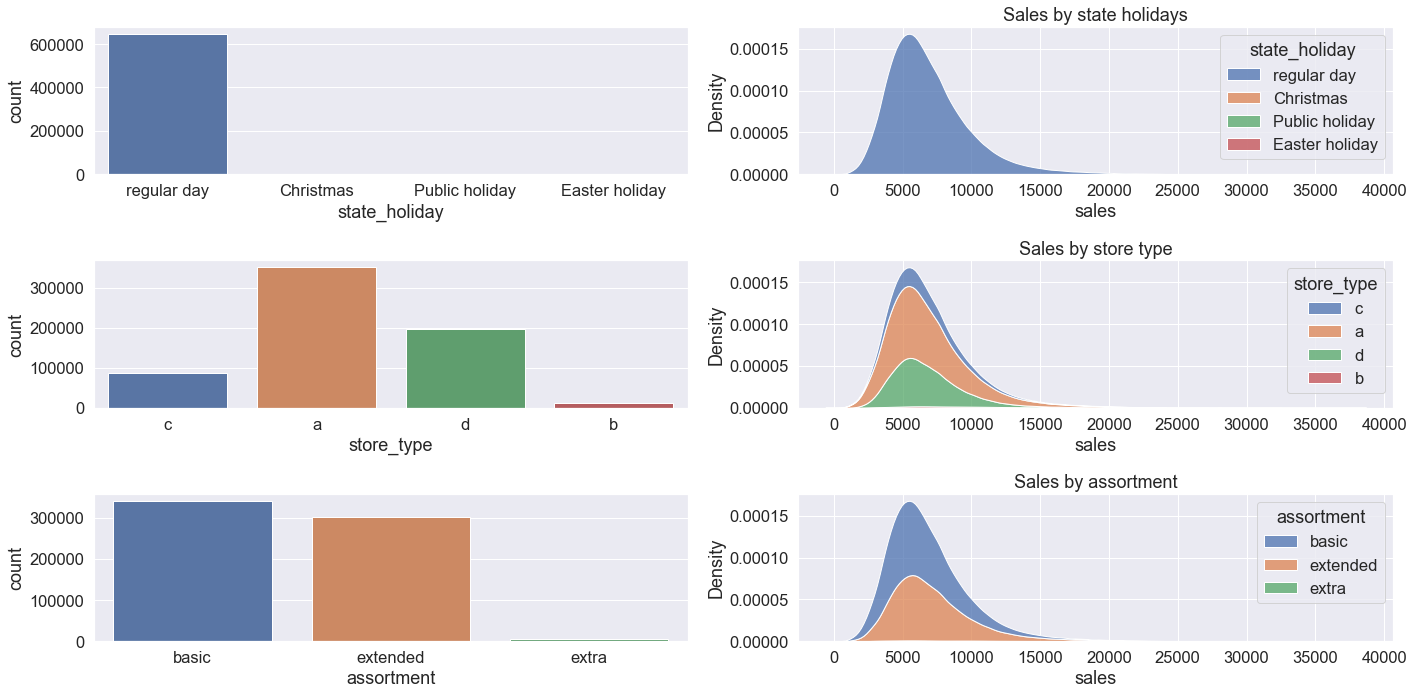

In [50]:
a = df4[df4['state_holiday'] != 'regular_day']

# sales by state holiday
plt.subplot(3,2,1)
sns.countplot(data = a, x = a["state_holiday"])

plt.subplot(3,2,2)
sns.kdeplot(data = df4, x = "sales", hue = a["state_holiday"], multiple = "stack").set_title("Sales by state holidays")


# sales by store type
plt.subplot(3,2,3)
sns.countplot(data = df4, x = df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(data = df4, x = "sales", hue = "store_type", multiple = "stack").set_title("Sales by store type")


# sales by assortment
plt.subplot(3,2,5)
sns.countplot(data = df4, x = df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot (data = df4, x = "sales", hue = "assortment", multiple = "stack").set_title("Sales by assortment");

plt.tight_layout()

## <font color=red>Bivariate Analysis

1. Stores with bigger assortment should sell more.
2. Stores with closer competitors should sell less.
3. Stores with longer competitors should sell more.
4. Stores with longer active promotions should sell more.
6. Stores with more consecutive promotions should sell more.
7. Stores open during Christmas holiday sHould sell more.
8. Stores should sell more over the years.
9. Stores should sell more in the second semester.
10. Stores should sell more after the 10th of each month.
11. Stores should sell less on weekends.
12. Stores should sell less during school holidays.

Hypothesis Resume

In [51]:
tab = [ ['Hypothesis', 'Conclusion', 'Relevance', 'Conclusion'],
        ['H1','True' ,'Low'   , 'Stores with bigger assortment sell more on average.'],
        ['H2','False','Medium', 'Stores with closer competitors sell more.'],
        ['H3','False','Medium', 'Stores with longer competitors sell less.'],
        ['H4','False','Low'   , 'Stores with longer active promotions sell less after a certain period of time.'],
        ['H5','False','Low'],
        ['H6','False','Low'],
        ['H7','False','Low'],
        ['H8','False','Low'],
        ['H9','False','High'],
        ['H10','True','High'],
        ['H11','True','High'],
        ['H12','True','High'],
      ]

print(tabulate(tab, headers = 'firstrow'))

Hypothesis    Conclusion    Relevance    Conclusion
------------  ------------  -----------  ------------------------------------------------------------------------------
H1            True          Low          Stores with bigger assortment sell more on average.
H2            False         Medium       Stores with closer competitors sell more.
H3            False         Medium       Stores with longer competitors sell less.
H4            False         Low          Stores with longer active promotions sell less after a certain period of time.
H5            False         Low
H6            False         Low
H7            False         Low
H8            False         Low
H9            False         High
H10           True          High
H11           True          High
H12           True          High


### Stores bigger more assortment should sell more.
**True:** Stores bigger more assortment sell more on average.

assortment,basic,extended,extra
avg_sales,6612.76,7229.01,8364.17
qty_stores,340937.00,301071.00,6301.00


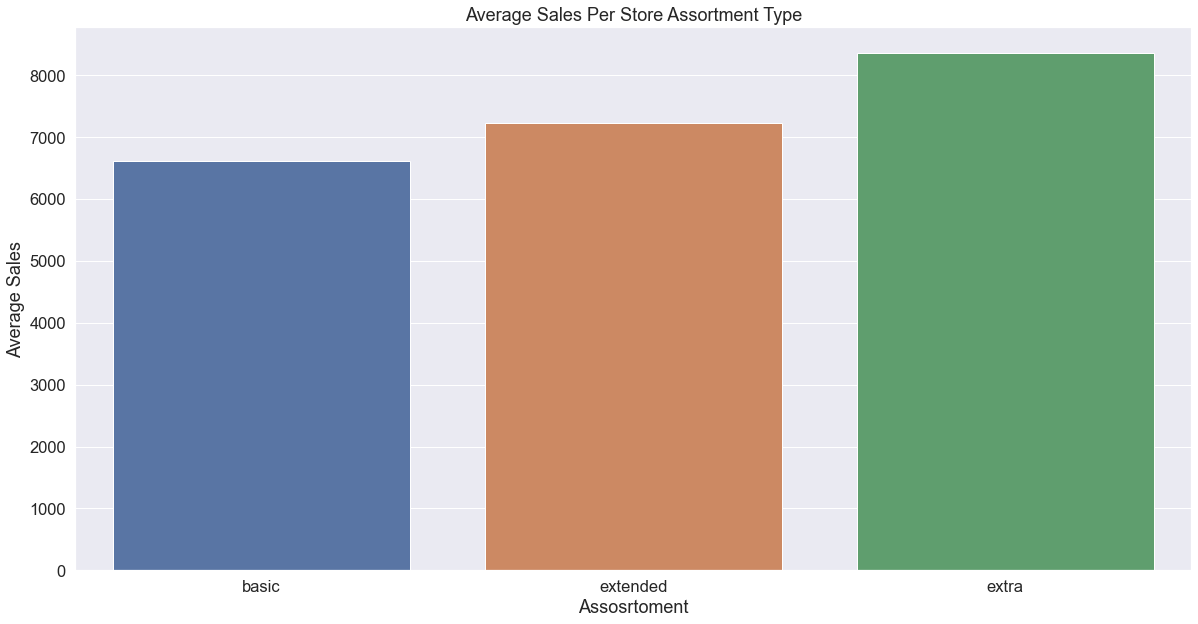

In [52]:
# checking sales by assortoment
a = df4[['store','assortment', 'sales']].copy()

b = (a.groupby('assortment').agg(qty_stores = ('store', 'count'),
                                 avg_sales  = ('sales', 'mean'))).reset_index()

c = pd.pivot_table(b, columns='assortment')
display(c)

ax = sns.barplot(data=b, x='assortment', y='avg_sales');
ax.set(xlabel="Assosrtoment", ylabel="Average Sales", title="Average Sales Per Store Assortment Type");

### Stores with closer competitors should sell less.
**False:** Stores with closer competitors sell more.

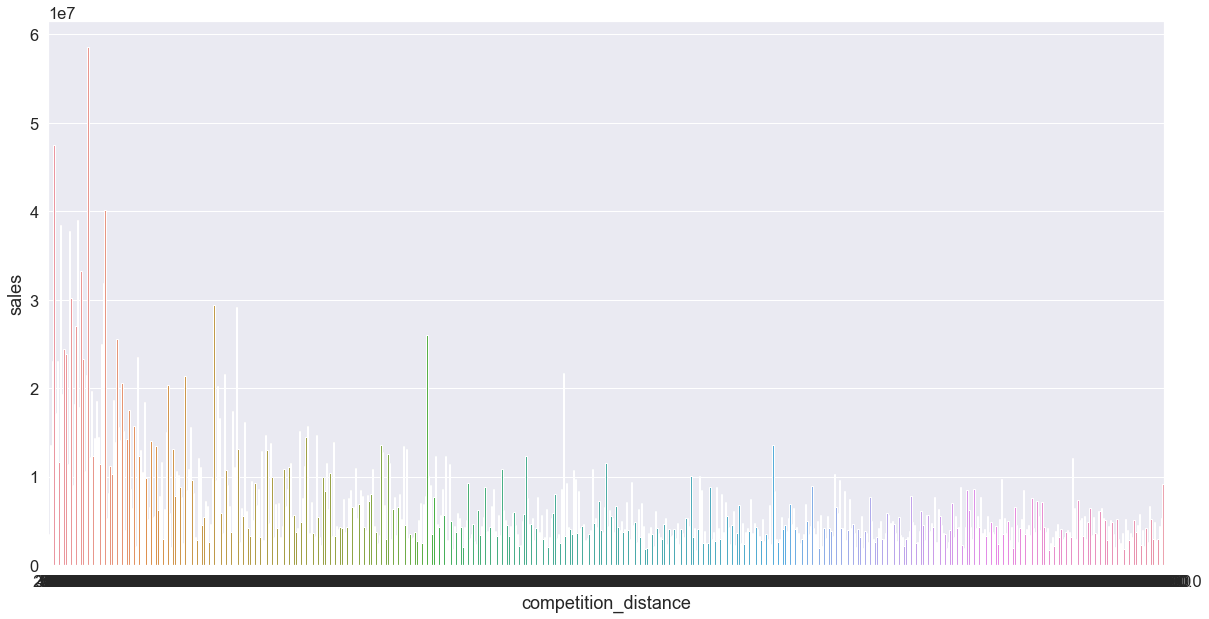

In [53]:
# checking sales by competition_distance
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.barplot(data = aux1, x='competition_distance', y='sales');

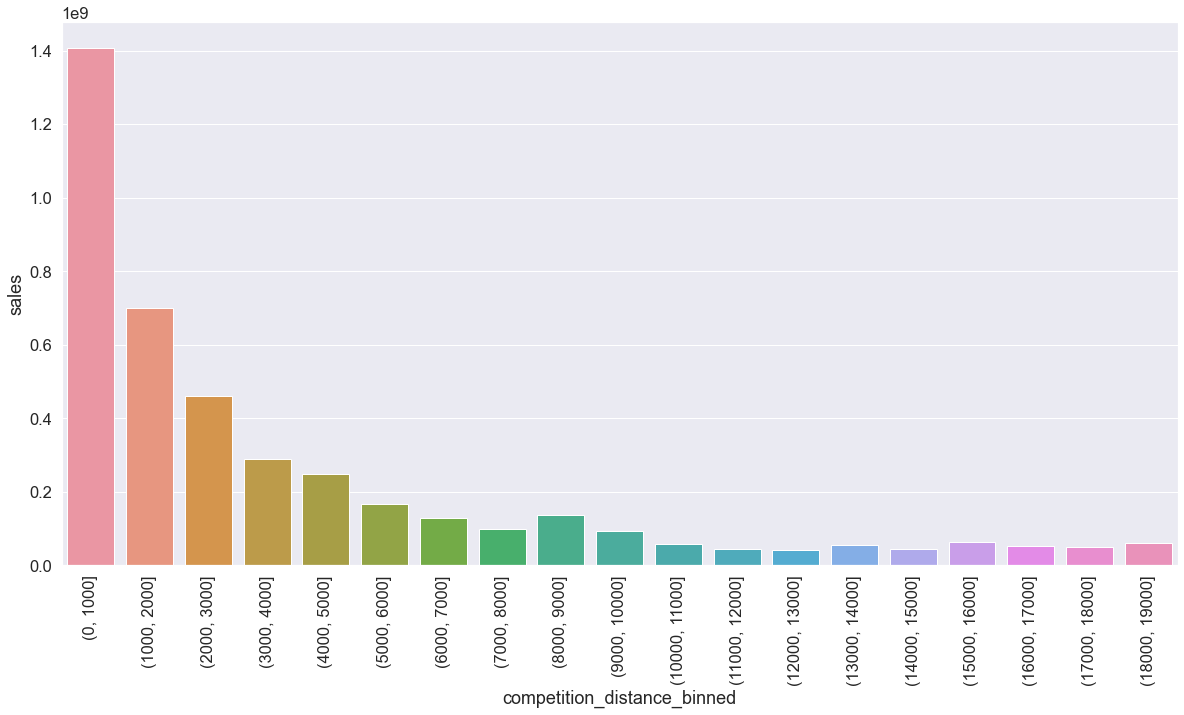

In [54]:
# grouping competition_distance in bins
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bingroup = list (np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bingroup)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data = aux2, x='competition_distance_binned', y='sales')
plt.xticks(rotation=90);

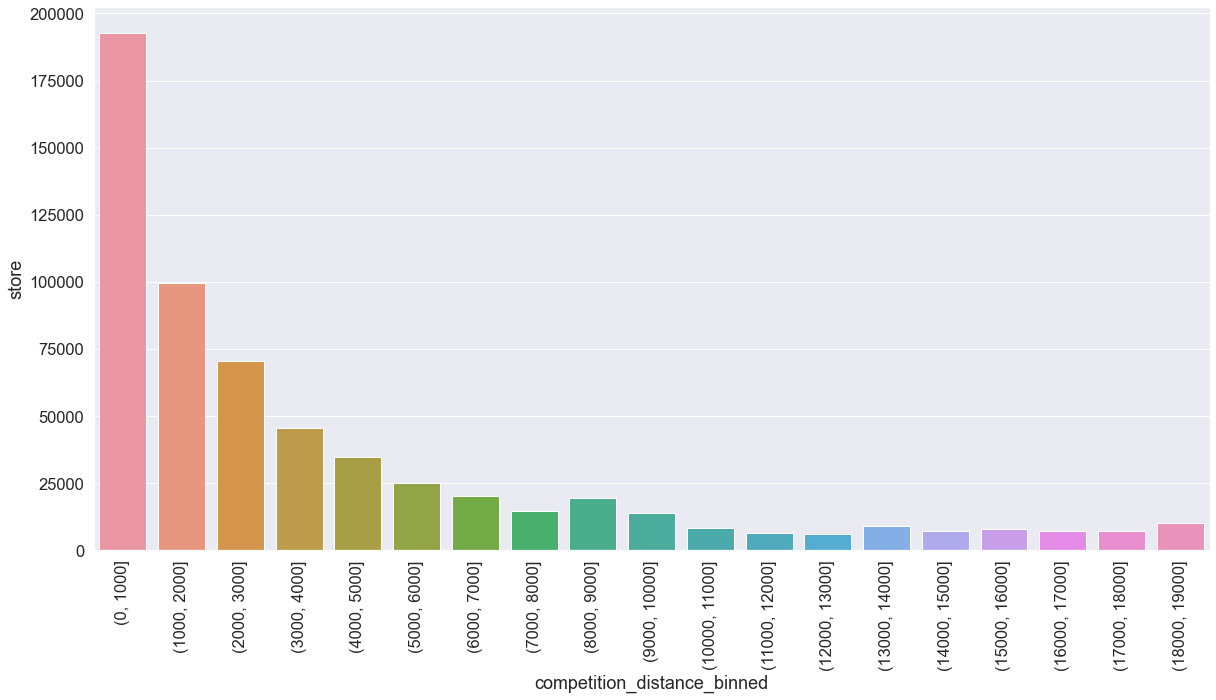

In [55]:
# grouping 'competition_distance' by number of stores

aux3 = df4[['competition_distance','store']].groupby('competition_distance').count().reset_index()

bingroup = list (np.arange(0,20000,1000))
aux3['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bingroup)

aux4 = aux3[['competition_distance_binned','store']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot (data = aux4, x = 'competition_distance_binned', y = 'store')
plt.xticks(rotation=90);

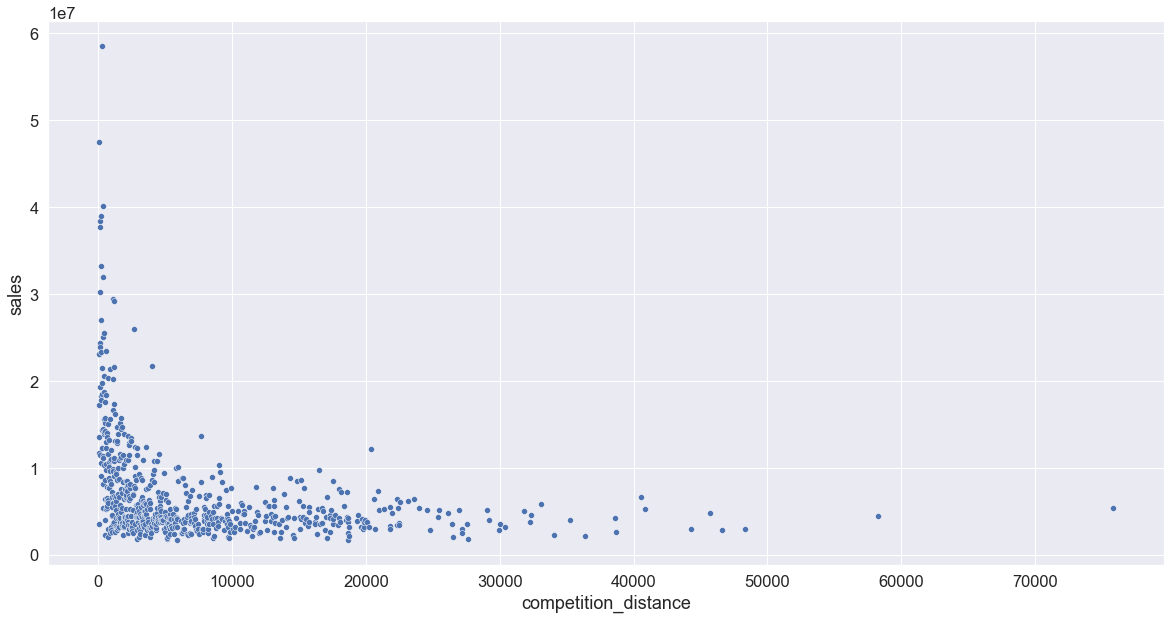

In [56]:
# checking 'competition_distance' distribution
aux1 = df4[df4['competition_distance']!=2000000][['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

sns.scatterplot(data = aux1, x='competition_distance', y='sales');

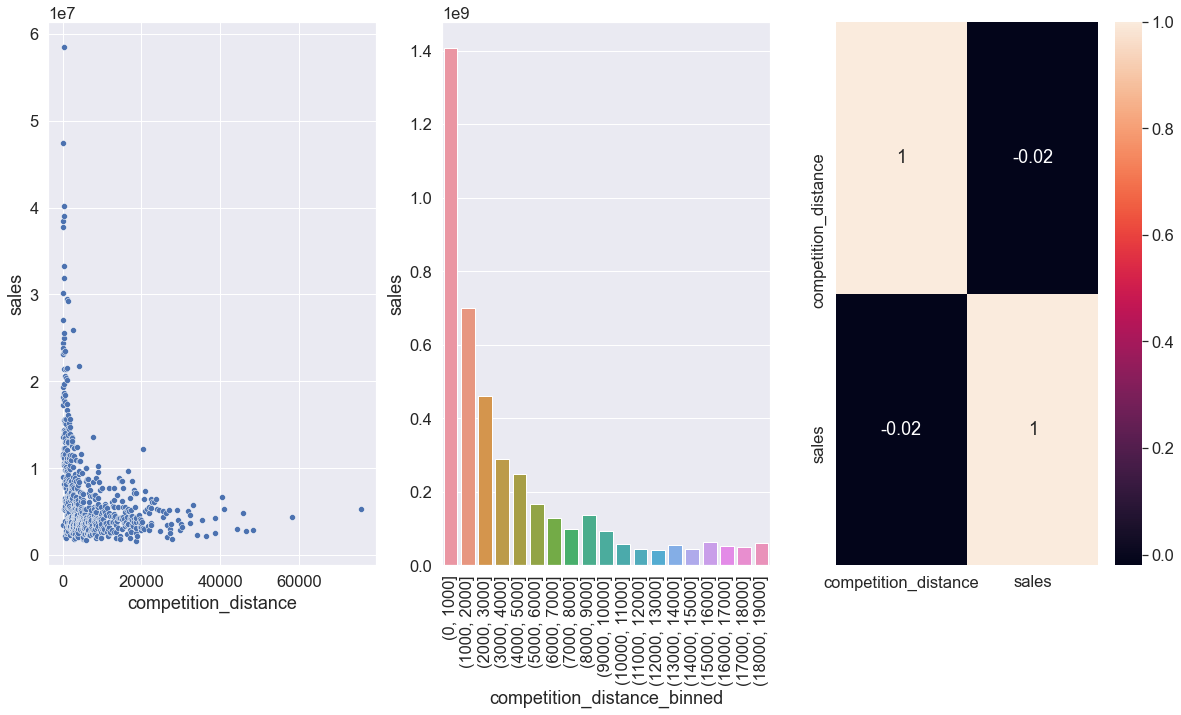

In [57]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot (1,3,1)
aux2 = aux1[aux1['competition_distance']!=2000000]
sns.scatterplot(x='competition_distance', y='sales', data=aux2);

plt.subplot (1,3,2)
bingroup = list (np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bingroup)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data = aux2, x='competition_distance_binned', y='sales')
plt.xticks(rotation=90);

plt.subplot (1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### Stores with longer competitors should sell more.
**False:** Stores with longer competitors sell less.

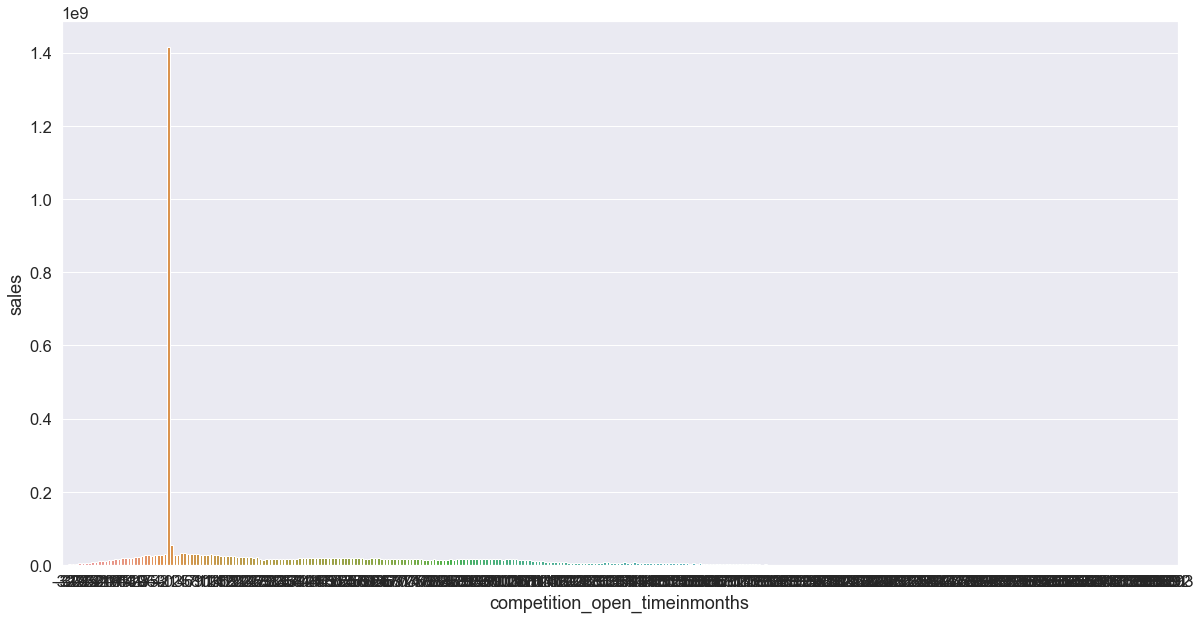

In [58]:
# checking 'sales' by 'competition_open_timeinmonths'
aux1 = df4[['competition_open_timeinmonths','sales']].groupby('competition_open_timeinmonths').sum().reset_index()
sns.barplot(data = aux1, x='competition_open_timeinmonths', y='sales');

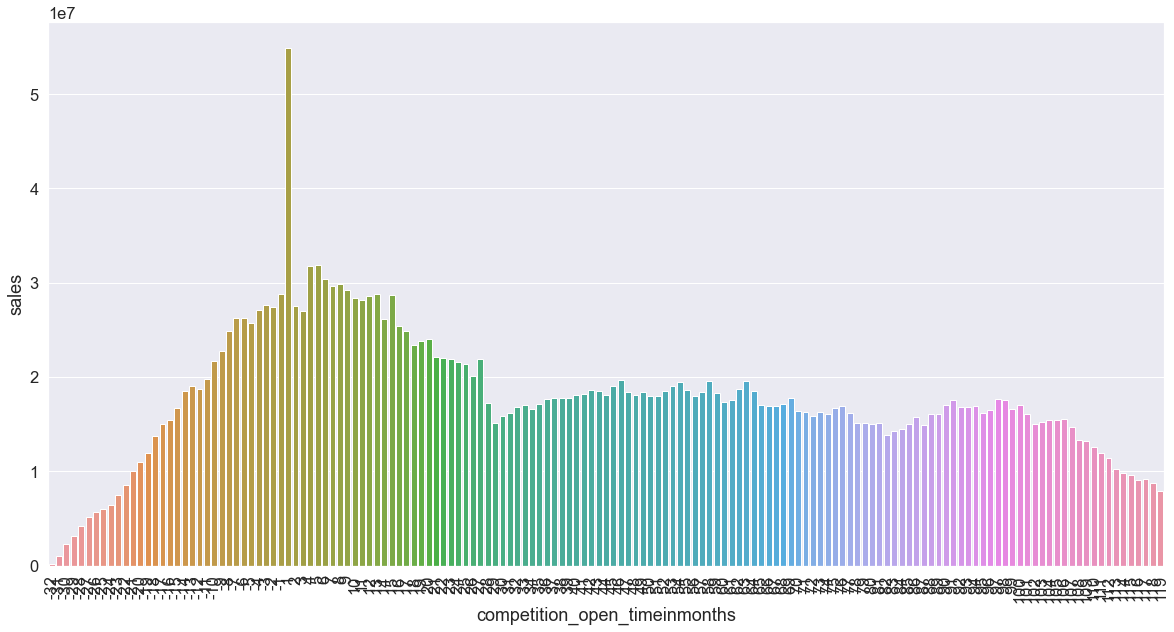

In [59]:
# checking 'competition_open_timeinmonths' lower than 120 months
aux1 = df4[['competition_open_timeinmonths','sales']].groupby('competition_open_timeinmonths').sum().reset_index()
aux2 = aux1[( aux1['competition_open_timeinmonths']<120 ) & ( aux1['competition_open_timeinmonths'] != 0)]

sns.barplot(data = aux2, x='competition_open_timeinmonths', y='sales');
plt.xticks(rotation=90);

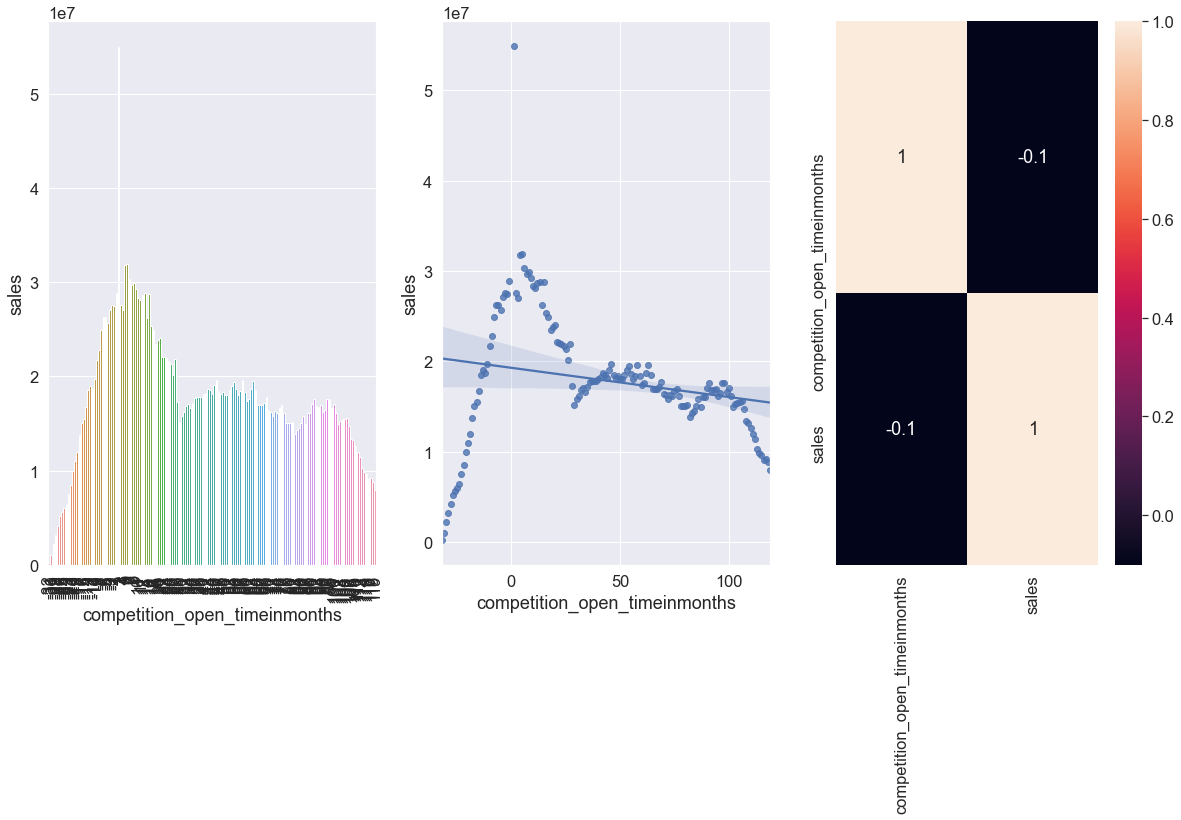

In [60]:
plt.subplot(1,3,1)
aux1 = df4[['competition_open_timeinmonths','sales']].groupby('competition_open_timeinmonths').sum().reset_index()
aux2 = aux1[( aux1['competition_open_timeinmonths']<120 ) & ( aux1['competition_open_timeinmonths']!=0)]
sns.barplot(data = aux2, x='competition_open_timeinmonths', y='sales');
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(data = aux2, x='competition_open_timeinmonths', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### Stores with longer active promotions should sell more.
**False:** Stores with longer active promotions sell less after a certain period of time.

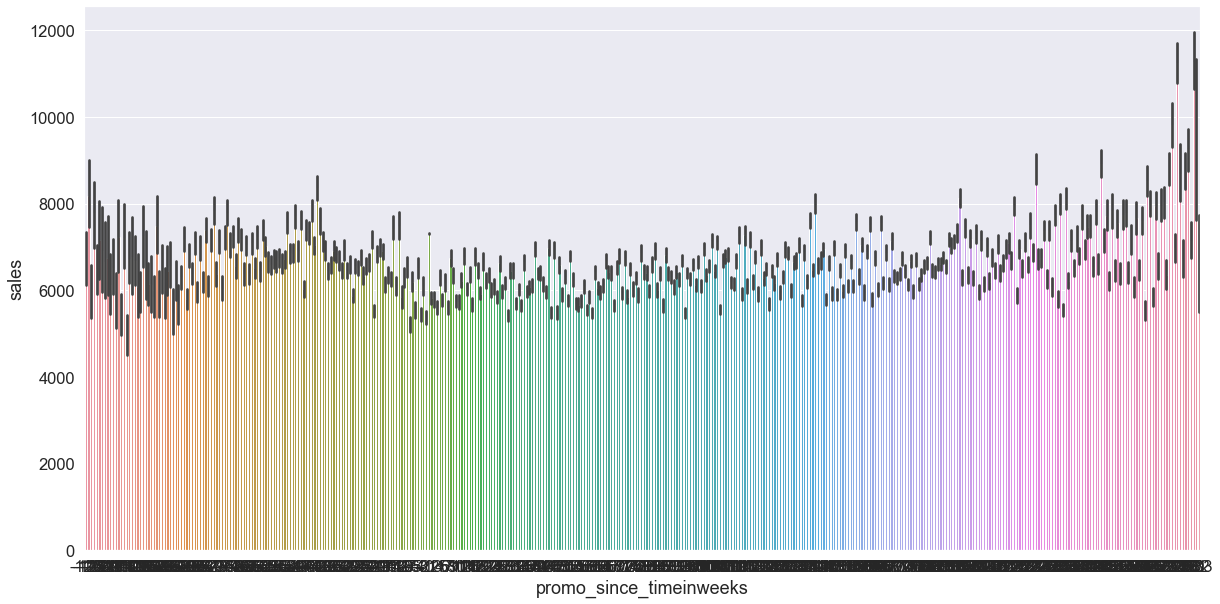

In [61]:
aux1 = df4[['promo_since_timeinweeks','sales']].groupby('promo_since_timeinweeks').sum().reset_index()
sns.barplot(data = df4, x = 'promo_since_timeinweeks', y = 'sales');

In [62]:
ax3 = aux1[aux1['promo_since_timeinweeks'] < 0]
sns.barplot(data = aux3, x = 'promo_since_timeinweeks', y = 'sales');
plt.xticks(rotation = 90);

ValueError: Could not interpret input 'promo_since_timeinweeks'

In [ ]:
aux2 = aux1[aux1['promo_since_timeinweeks'] > 0]
sns.barplot(data = aux2, x = 'promo_since_timeinweeks', y = 'sales');
plt.xticks(rotation = 90);

In [ ]:
aux1 = df4[['promo_since_timeinweeks','sales']].groupby('promo_since_timeinweeks').sum().reset_index()

dash = gridspec.GridSpec(2,3)

plt.subplot(dash [0,0])
aux2 = aux1[aux1['promo_since_timeinweeks'] > 0]
sns.barplot(data = aux2, x = 'promo_since_timeinweeks', y = 'sales');
plt.xticks(rotation = 90);

plt.subplot(dash [0,1])
sns.regplot(data = aux2, x = 'promo_since_timeinweeks', y = 'sales');

plt.subplot(dash [1,0])
aux3 = aux1[aux1['promo_since_timeinweeks'] < 0]
sns.barplot(data = aux3, x = 'promo_since_timeinweeks', y = 'sales');
plt.xticks(rotation = 90);

plt.subplot(dash [1,1])
sns.regplot(data = aux3, x = 'promo_since_timeinweeks', y = 'sales');

plt.subplot(dash [:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [ ]:
sns.regplot(data = aux2, x='competition_open_timeinmonths', y='sales');

### <font color=red>Stores with more consecutive promotions should sell more.

In [ ]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().sort_values('sales', ascending=True).reset_index()

In [ ]:
# stores that participated on tradicional and extended promo
aux1 = df4[(df4['promo'] ==1) & (df4['promo2'] ==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

# stores that participated only on tradicional promo
aux2 = df4[(df4['promo'] ==1) & (df4['promo2'] ==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels = ['Tradicional and Extended', 'Tradicional']);
plt.xlabel('year_week');
plt.ylabel('sales');

In [ ]:
# stores that participated on tradicional and extended promo
aux1 = df4[(df4['promo'] ==1) & (df4['promo2'] ==1)][['date','sales']].groupby('date').sum().reset_index()
ax = aux1.plot();

# stores that participated only on tradicional promo
aux2 = df4[(df4['promo'] ==1) & (df4['promo2'] ==0)][['date','sales']].groupby('date').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels = ['Tradicional and Extended', 'Tradicional']);
plt.xlabel('date');
plt.ylabel('sales');

In [ ]:
# stores that participated on tradicional and extended promo
aux1 = df4[(df4['promo'] ==1) & (df4['promo2'] ==1)][['year','sales']].groupby('year','').sum().reset_index()
sns.barplot(data=aux1, x ='year', y = 'sales');
display(aux1)

plt.legend(labels = ['Tradicional and Extended', 'Tradicional']);
plt.xlabel('year_week');
plt.ylabel('sales');

In [ ]:
# stores that participated only on tradicional promo
aux2 = df4[(df4['promo'] ==1) & (df4['promo2'] ==0)][['year','sales']].groupby('year').sum().reset_index()
sns.barplot(data=aux2, x ='year', y = 'sales');

display(aux2)




In [ ]:
# stores that participated on tradicional and extended promo
aux1 = df4[(df4['promo'] ==1) & (df4['promo2'] ==1 & (df4['year']==2013))][['year','sales']].groupby('year').sum().reset_index()
ax = aux1.plot();

# stores that participated only on tradicional promo
aux2 = df4[(df4['promo'] ==1) & (df4['promo2'] ==0) & (df4['year']==2013)][['year','sales']].groupby('year').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels = ['Tradicional and Extended', 'Tradicional']);
# plt.xlabel('year_week');
# plt.ylabel('sales');

display(aux1)
display(aux2)

In [ ]:
# stores that participated on tradicional and extended promo
aux1 = df4[(df4['promo'] ==1) & (df4['promo2'] ==1 & (df4['year']==2014))][['year','sales']].groupby('year').sum().reset_index()
ax = aux1.plot();

# stores that participated only on tradicional promo
aux2 = df4[(df4['promo'] ==1) & (df4['promo2'] ==0) & (df4['year']==2014)][['year','sales']].groupby('year').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels = ['Tradicional and Extended', 'Tradicional']);
plt.xlabel('year_week');
plt.ylabel('sales');

display(aux1)
display(aux2)

### <font color=red>Stores open during Christmas holiday should sell more.

In [ ]:
# checking 'sales' by 'state_holiday'
aux = df4[df4['state_holiday'] != 'regular day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(data = aux1, x = 'state_holiday', y = 'sales');

display(aux1)

In [ ]:
# checking 'sales' by 'state_holiday' and 'year'
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(data = aux2, x = 'year', y='sales', hue='state_holiday');

display(aux2)

### Stores should sell more over the years.
**False:** Stores are selling less over the years.

In [ ]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data = aux1, x = 'year', y = 'sales');

plt.subplot(1,3,2)
sns.regplot(data = aux1, x = 'year', y = 'sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### Stores should sell more in the second semester.

In [ ]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data = aux1, x = 'month', y = 'sales');

plt.subplot(1,3,2)
sns.regplot(data = aux1, x = 'month', y = 'sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# próximo ciclo agrupar vendas de meses 1 a 6 e 7 a 12

### Stores should sell more after the 10th of each month.

In [ ]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
aux1['before_after10'] = aux1['day'].apply (lambda x: 'before_day10' if x <= 10 else 'after_day10')

plt.subplot(2,2,1)
sns.barplot(data = aux1, x = 'day', y = 'sales');

plt.subplot(2,2,2)
sns.regplot(data = aux1, x = 'day', y = 'sales');

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux2 = aux1[['before_after10','sales']].groupby('before_after10').sum().reset_index()
sns.barplot(data = aux2, x = 'before_after10', y = 'sales');

# próximo ciclo: calcular média de vendas por dia nos dez primeiros dias, e depois a média de vendas nos demais vinte dias, ou fazer três grupos de 10 dias cada.

### Stores should sell less on weekends.

In [ ]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data = aux1, x = 'day_of_week', y = 'sales');

plt.subplot(1,3,2)
sns.regplot(data = aux1, x = 'day_of_week', y = 'sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# próximo ciclo: avaliar a frequência que as lojas ficam abertas aos fins de semana.

### Stores should sell less during school holidays.

In [ ]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()

plt.subplot(2,1,1)
sns.barplot(data = aux1, x = 'school_holiday', y = 'sales')

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot(data = aux2, x = 'month', y = 'sales', hue='school_holiday');

# próximo ciclo: fazer média de vendas em dias comuns vs. média de vendas em dias de feriados escolares.

## Multivariate Analysis

### Numerical Attributes

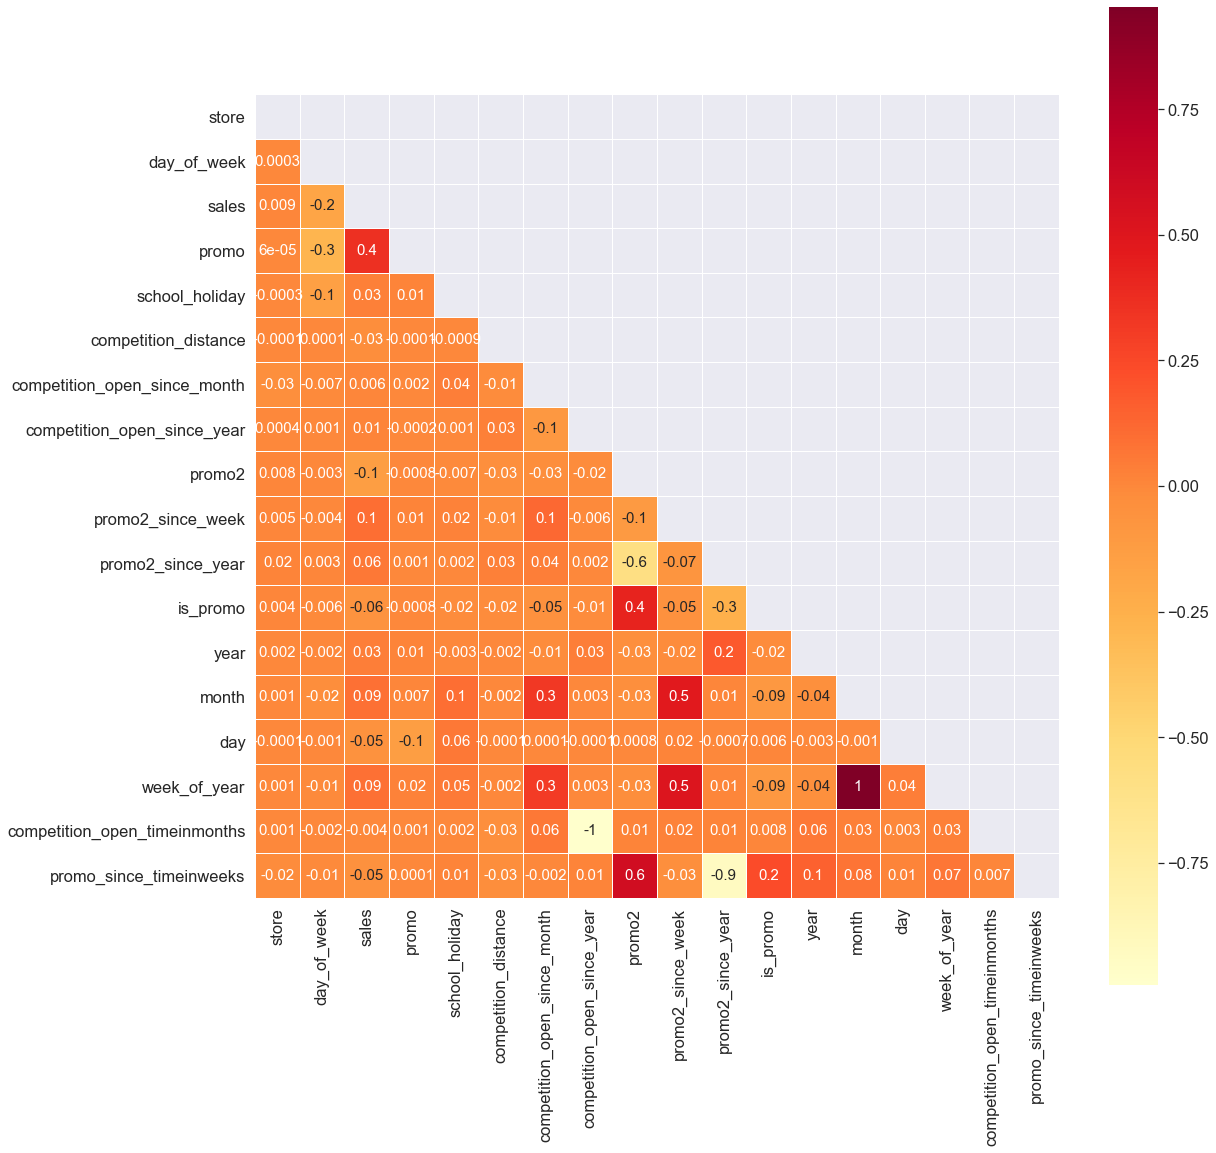

In [63]:
correlation = num_df4.corr(method = 'pearson')

corr_mask = np.triu(correlation)

plt.figure(figsize=(18,18))
sns.heatmap(correlation, 
            cmap='YlOrRd', 
            annot=True, 
            annot_kws={'fontsize':'small'},
            fmt='.1g',
            linewidths=0.8, 
            square=True,
            mask=corr_mask);

### Categorical Attributes

In [64]:
df4.dtypes

store                                     int64
day_of_week                               int64
date                             datetime64[ns]
sales                                     int64
promo                                     int64
state_holiday                            object
school_holiday                            int64
store_type                               object
assortment                               object
competition_distance                    float64
competition_open_since_month              int64
competition_open_since_year               int64
promo2                                    int64
promo2_since_week                         int64
promo2_since_year                         int64
is_promo                                  int64
year                                      int64
month                                     int64
day                                       int64
week_of_year                              int64
year_week                               

               state_holiday  store_type  assortment
state_holiday           1.00        0.07        0.07
store_type              0.07        1.00        0.54
assortment              0.07        0.54        1.00 



<AxesSubplot:>

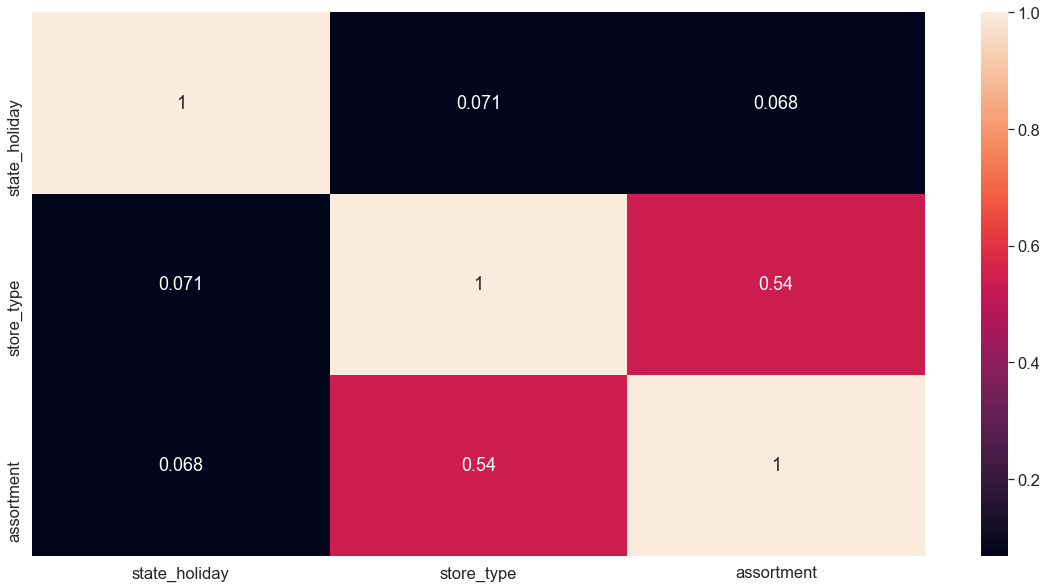

In [65]:
# calculating Cramer V (formula at Helper Function section)

a1 = cramer_v(cat_df4['state_holiday'], cat_df4['state_holiday'])
a2 = cramer_v(cat_df4['state_holiday'], cat_df4['store_type'])
a3 = cramer_v(cat_df4['state_holiday'], cat_df4['assortment'])

a4 = cramer_v(cat_df4['store_type'], cat_df4['state_holiday'])
a5 = cramer_v(cat_df4['store_type'], cat_df4['store_type'])
a6 = cramer_v(cat_df4['store_type'], cat_df4['assortment'])

a7 = cramer_v(cat_df4['assortment'], cat_df4['state_holiday'])
a8 = cramer_v(cat_df4['assortment'], cat_df4['store_type'])
a9 = cramer_v(cat_df4['assortment'], cat_df4['assortment'])

# final dataset 
t = pd.DataFrame({'state_holiday': [ a1,a2,a3],
                  'store_type':    [ a4,a5,a6],
                  'assortment':    [ a7,a8,a9]})

t = t.set_index(t.columns)
print (t, '\n')

sns.heatmap (data=t, annot=True)

# DATA PREPARATION

In [66]:
df5=df3.copy() # copying from df3 with full date range

## Rescaling

In [67]:
num_df5 = df5.select_dtypes(include=['int64','float64'])
num_df5.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_open_timeinmonths,promo_since_timeinweeks
0,1,5,5263,1,1,1270.00,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.00,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.00,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.00,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.00,4,2015,0,31,2015,0,2015,7,31,31,4,0


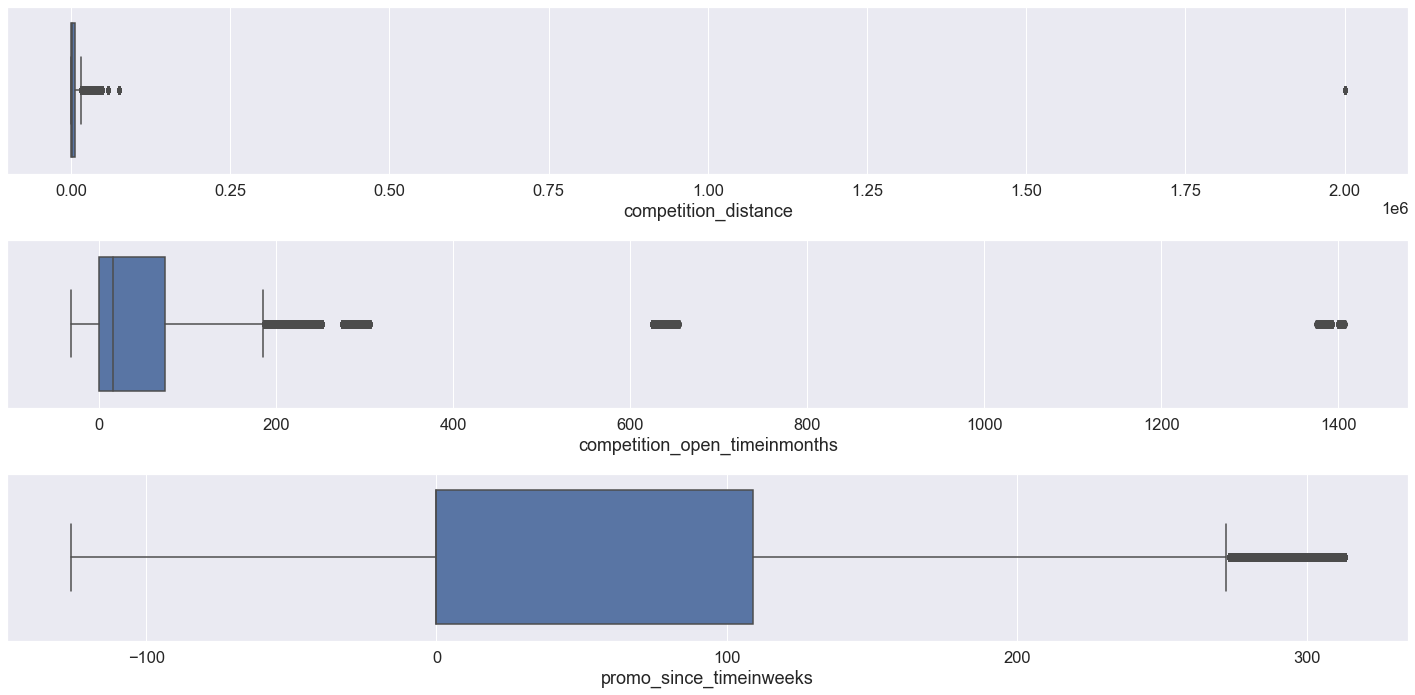

In [68]:
# checking outliers

# competition_distance
plt.subplot(3,1,1)
sns.boxplot(data=df5, x=df5['competition_distance']);

# competition_open_timeinmonths
plt.subplot(3,1,2)
sns.boxplot(data=df5, x=df5['competition_open_timeinmonths']);

# promo_since_timeinweeks
plt.subplot(3,1,3)
sns.boxplot(data=df5, x=df5['promo_since_timeinweeks']);

plt.tight_layout()

In [69]:
# rescaling

rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_open_timeinmonths
df5['competition_open_timeinmonths'] = rs.fit_transform(df5[['competition_open_timeinmonths']].values)

# promo_since_timeinweeks
df5['promo_since_timeinweeks'] = mms.fit_transform(df5[['promo_since_timeinweeks']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)



df5[['competition_distance', 'competition_open_timeinmonths', 'promo_since_timeinweeks']].head()

,competition_distance,competition_open_timeinmonths,promo_since_timeinweeks
0,-0.17,0.92,0.29
1,-0.28,1.05,0.92
2,1.90,1.20,0.80
3,-0.28,0.74,0.29
4,4.45,-0.16,0.29


In [70]:
# v_max = df5['competition_distance'].max()
# sns.displot(df5['competition_distance']< v_max);

## Transforming

### Encoding

In [71]:
df52 = df5.copy()

cat_df5 = df5.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
cat_df5.head()

,state_holiday,store_type,assortment,year_week
0,regular day,c,basic,2015-30
1,regular day,a,basic,2015-30
2,regular day,a,basic,2015-30
3,regular day,c,extended,2015-30
4,regular day,a,basic,2015-30


In [72]:
# state_holiday - one hot enconding (each holiday becomes a column)
df52 = pd.get_dummies(df52, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - label enconding (each type becomes a value in a range)
le = preprocessing.LabelEncoder()
df52['store_type'] = le.fit_transform(df52['store_type'])

# assortment - ordinal enconding (each assortment becomes a value in a hierarchy)
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df52['assortment'] = df52['assortment'].map(assortment_dict)

df52.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_open_since,competition_open_timeinmonths,promo_since,promo_since_timeinweeks,state_holiday_Christmas,state_holiday_Easter holiday,state_holiday_Public holiday,state_holiday_regular day
0,1,5,2015-07-31,5263,1,1,2,1,-0.17,9,...,31,2015-30,2008-09-01,0.92,2015-07-27,0.29,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.28,11,...,31,2015-30,2007-11-01,1.05,2010-03-22,0.92,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.90,12,...,31,2015-30,2006-12-01,1.20,2011-03-28,0.80,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.28,9,...,31,2015-30,2009-09-01,0.74,2015-07-27,0.29,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.45,4,...,31,2015-30,2015-04-01,-0.16,2015-07-27,0.29,0,0,0,1


### Response Variable Transformation

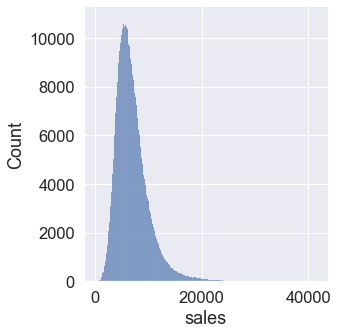

In [73]:
sns.displot(df52['sales']);

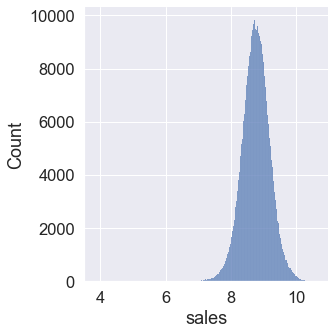

In [74]:
df52['sales'] = np.log1p(df52['sales'])
sns.displot(df52['sales']);

### Nature Transformation

In [75]:
# month
df52['month_sin'] = df52['month'].apply(lambda x: np.sin(x*(2*np.pi/12))) 
df52['month_cos'] = df52['month'].apply(lambda x: np.cos(x*(2*np.pi/12))) 

# week_of_year
df52['week_of_year_sin'] = df52['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52))) 
df52['week_of_year_cos'] = df52['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52))) 

# day
df52['day_sin'] = df52['day'].apply(lambda x: np.sin(x*(2*np.pi/30))) 
df52['day_cos'] = df52['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# day_of_week
df52['day_of_week_sin'] = df52['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7))) 
df52['day_of_week_cos'] = df52['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))



df52.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_Public holiday,state_holiday_regular day,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.57,1,1,2,1,-0.17,9,...,0,1,-0.50,-0.87,-0.57,-0.82,0.21,0.98,-0.97,-0.22
1,2,5,2015-07-31,8.71,1,1,0,1,-0.28,11,...,0,1,-0.50,-0.87,-0.57,-0.82,0.21,0.98,-0.97,-0.22
2,3,5,2015-07-31,9.03,1,1,0,1,1.90,12,...,0,1,-0.50,-0.87,-0.57,-0.82,0.21,0.98,-0.97,-0.22
3,4,5,2015-07-31,9.55,1,1,2,3,-0.28,9,...,0,1,-0.50,-0.87,-0.57,-0.82,0.21,0.98,-0.97,-0.22
4,5,5,2015-07-31,8.48,1,1,0,1,4.45,4,...,0,1,-0.50,-0.87,-0.57,-0.82,0.21,0.98,-0.97,-0.22


# FEATURE SELECTION

In [76]:
df6 = df52.copy()
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_Public holiday,state_holiday_regular day,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.57,1,1,2,1,-0.17,9,...,0,1,-0.50,-0.87,-0.57,-0.82,0.21,0.98,-0.97,-0.22
1,2,5,2015-07-31,8.71,1,1,0,1,-0.28,11,...,0,1,-0.50,-0.87,-0.57,-0.82,0.21,0.98,-0.97,-0.22
2,3,5,2015-07-31,9.03,1,1,0,1,1.90,12,...,0,1,-0.50,-0.87,-0.57,-0.82,0.21,0.98,-0.97,-0.22
3,4,5,2015-07-31,9.55,1,1,2,3,-0.28,9,...,0,1,-0.50,-0.87,-0.57,-0.82,0.21,0.98,-0.97,-0.22
4,5,5,2015-07-31,8.48,1,1,0,1,4.45,4,...,0,1,-0.50,-0.87,-0.57,-0.82,0.21,0.98,-0.97,-0.22


## Training and Test dataset

In [77]:
# deleting columns that derived other features
dropcols = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_open_since', 'year_week']
df6 = df6.drop(dropcols, axis=1)
df6.shape

(844338, 29)

In [78]:
# Checking 'date' intervals
print(df6[['store', 'date']].groupby('store').min().reset_index()['date'][0], '-> First date')
print(df6[['store', 'date']].groupby('store').max().reset_index()['date'][0], '-> Last date', )
print(df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7), '-> Six weeks before last date')

2013-01-02 00:00:00 -> First date
2015-07-31 00:00:00 -> Last date
2015-06-19 00:00:00 -> Six weeks before last date


In [79]:
# Training Dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print()
print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Boruta as Feature Selection

In [100]:
# training and test datset for Boruta
X_train_blist = X_train.drop(['date', 'sales'], axis=1).values # array
Y_train_blist = Y_train.values.ravel() # array

# defining Radom Forest Regressor
rf = RandomForestRegressor(n_jobs=-1) # pararel processing

# defining Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_blist, Y_train_blist)

KeyboardInterrupt: 

In [ ]:
cols_selected_blist = boruta.support_.tolist() # list of features boruta selected in boolean format
X_train_FS = X_train.drop(['date', 'sales'], axis=1) # deleting cols from X_train to read next step

# Features Selected from Boruta
cols_selected_boruta = X_train_FS.iloc[:, cols_selected_blist].columns.to_list() # list of columns boruta selected

# Features not Selected from Boruta
cols_notselected_boruta = list(np.setdiff1d(X_train_FS.columns, cols_selected_boruta)) # list of columns boruta did not select

## Manual Feature Selection

In [80]:
cols_selected_boruta

NameError: name 'cols_selected_boruta' is not defined

In [81]:
# Features Selected from Boruta
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_open_timeinmonths',
 'promo_since_timeinweeks',
 'month_sin', # added manually
 'month_cos',
 'week_of_year_sin', # added manually
 'week_of_year_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# features to add
features_added = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(features_added)

cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_open_timeinmonths',
 'promo_since_timeinweeks',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']

# MACHINE LEARNING MODELING

In [82]:
# X_train only with columns selected by boruta // X_train = df6[df6['date'] < '2015-06-19']
x_train_colsb = X_train[cols_selected_boruta] 

# X_test only with columns selected by boruta // X_test = df6[df6['date'] >= '2015-06-19']
x_test_colsb = X_test[cols_selected_boruta] 

# X_train with boruta columns + dates + sales // time series data preparation
x_training_colsfull = X_train[cols_selected_boruta_full]

## Average Model

In [83]:
aux1 = x_test_colsb.copy() # X_test with columns selected with boruta
aux1['sales'] = Y_test.copy() # Y_test = X_test['sales']
aux1.head() # kind of 'original' dataset but only with selected columns with boruta

# creating prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'mean_prediction'}) # calculating mean sales by store
aux3 = pd.merge(aux1, aux2, how='left', on='store') # merging with aux1 dataframe to add 'mean_prediction' to the dataset

# ŷ -> predicted value
yhat_baseline = aux3['mean_prediction'] 

# performance analysis // ml_error(model_name, y, yhat):
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline)) # function created // transformation to exponential needed because it was used 'log' in 'sales' on 5.3.2 Response Variable Transformation
baseline_result

,Model Name,MAE,MAPE,RSME
0,Average Model,1354.80,0.21,1835.14


## Linear Regression Model

In [84]:
# model
lr = LinearRegression().fit(x_train_colsb, Y_train)

# creating prediction
yhat_lr = lr.predict(x_test_colsb) # ŷ -> predicted value

# performance // ml_error(model_name, y, yhat):
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr)) # ml_error(model_name, y, yhat) // y: real values, yhat: predicted values
lr_result

,Model Name,MAE,MAPE,RSME
0,Linear Regression,1863.63,0.29,2673.14


## Linear Regression Regularized Model - Lasso

In [85]:
# model
lrr = Lasso(alpha=0.01).fit(x_train_colsb, Y_train)

# creating prediction
yhat_lrr = lrr.predict(x_test_colsb) # ŷ -> predicted value


# performance // ml_error(model_name, y, yhat):
lrr_result = ml_error('Linear Regression Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RSME
0,Linear Regression Lasso,1889.98,0.29,2745.97


## Random Forest Regressor

In [86]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train_colsb, Y_train)

# creating prediction
yhat_rf = rf.predict(x_test_colsb) # ŷ -> predicted value


# performance // ml_error(model_name, y, yhat):
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RSME
0,Random Forest Regressor,678.96,0.10,1009.80


## XGBoost

In [87]:
# model
xgbm = xgb.XGBRegressor(objective='reg:squarederror',
                        n_estimators=100, 
                        eta=0.01, 
                        max_depth=10,
                        subsample=0.7,
                        colsample_bytree=0.9).fit(x_train_colsb, Y_train)

# creating prediction
yhat_xgb = xgbm.predict(x_test_colsb) # ŷ -> predicted value
yhat_xgb

# performance // ml_error(model_name, y, yhat):
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RSME
0,XGBoost Regressor,6683.36,0.95,7330.67


## Models Performance Comparison

### Single Performance

In [88]:
comparison_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
comparison_result.sort_values('RSME', ascending=True)

,Model Name,MAE,MAPE,RSME
0,Random Forest Regressor,678.96,0.10,1009.80
0,Average Model,1354.80,0.21,1835.14
0,Linear Regression,1863.63,0.29,2673.14
0,Linear Regression Lasso,1889.98,0.29,2745.97
0,XGBoost Regressor,6683.36,0.95,7330.67


### Real Performance - Cross Validation

In [89]:
# cross_validation(x_training, kfold, model_name, model, verbose=False)

In [90]:
# Linear Regression
lr_result_cv = cross_validation(x_training_colsfull, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE Mean CV,MAPE Mean CV,RMSE Mean CV
0,Linear Regression,2083.17 +/- 294.98,0.3 +/- 0.02,2958.87 +/- 466.72


In [91]:
# Linear Regularized Model - Lasso
lrr_result_cv = cross_validation(x_training_colsfull, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE Mean CV,MAPE Mean CV,RMSE Mean CV
0,Lasso,2063.95 +/- 292.89,0.3 +/- 0.01,2941.37 +/- 452.31


In [92]:
# Random Forest
rf_result_cv = cross_validation(x_training_colsfull, 5, 'Radom Forest Regressor', rf, verbose=True)
rf_result_cv


 Kfold number: 5

 Kfold number: 4

 Kfold number: 3

 Kfold number: 2

 Kfold number: 1


,Model Name,MAE Mean CV,MAPE Mean CV,RMSE Mean CV
0,Radom Forest Regressor,2063.95 +/- 292.89,0.3 +/- 0.01,2941.37 +/- 452.31


In [93]:
# XGBoost
xgb_result_cv = cross_validation(x_training_colsfull, 5, 'XGBoost Regressor', xgbm, verbose=False)
xgb_result_cv

,Model Name,MAE Mean CV,MAPE Mean CV,RMSE Mean CV
0,XGBoost Regressor,2063.95 +/- 292.89,0.3 +/- 0.01,2941.37 +/- 452.31


In [94]:
# Comparison Table - Cross Validation
comparison_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
comparison_result_cv

,Model Name,MAE Mean CV,MAPE Mean CV,RMSE Mean CV
0,Linear Regression,2083.17 +/- 294.98,0.3 +/- 0.02,2958.87 +/- 466.72
0,Lasso,2063.95 +/- 292.89,0.3 +/- 0.01,2941.37 +/- 452.31
0,Radom Forest Regressor,2063.95 +/- 292.89,0.3 +/- 0.01,2941.37 +/- 452.31
0,XGBoost Regressor,2063.95 +/- 292.89,0.3 +/- 0.01,2941.37 +/- 452.31


In [95]:
# Comparision Table - Single Performance
comparison_result

,Model Name,MAE,MAPE,RSME
0,Average Model,1354.80,0.21,1835.14
0,Linear Regression,1863.63,0.29,2673.14
0,Linear Regression Lasso,1889.98,0.29,2745.97
0,Random Forest Regressor,678.96,0.10,1009.80
0,XGBoost Regressor,6683.36,0.95,7330.67


# <font color=red>HYPER PARAMETER FINE TUNING

## Random Search

In [97]:
param_dict = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
              'eta': [0.01, 0.03],
              'max_depth': [3, 6, 9],
              'subsample': [0.1, 0.5, 0.7],
              'colsample_bytree': [0.3, 0.5, 0.8, 1],
              'min_child_weight': [1, 3, 8, 15]}

max_eval = 10

In [101]:
final_result = pd.DataFrame()

for i in range(max_eval):
    
    # choose random param values
    hp = {k: random.sample(v, 1)[0] for k, v in param_dict.items()}
    
    # print selected values
    print(hp)
    
    #store in list
    #hyperparam_list.append(hp.copy())

    # model
    xgbm = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=hp['n_estimators'], 
                            eta=hp['eta'], 
                            max_depth=hp['max_depth'],
                            subsample=hp['subsample'],
                            colsample_bytree=hp['colsample_bytree'],
                            min_child_weight=hp['min_child_weight'])

    
    # performance
    xgb_result = cross_validation(x_training_colsfull, 10, 'XGBoost Regressor', xgbm, verbose=False)
    final_result = pd.concat([final_result, xgb_result])
    
    
final_result

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 6, 'subsample': 0.1, 'colsample_bytree': 0.8, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 1}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 1, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 6, 'subsample': 0.1, 'colsample_bytree': 0.8, 'min_child_weight': 3}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 6, 'subsample': 0.1, 'colsample_bytree': 0.8, 'min_child_weight': 1}


KeyboardInterrupt: 

## Final Model

In [ ]:
# tuned_param_dict = {'n_estimators': ,
#                       'eta': ,
#                       'max_depth': ,
#                       'subsample': ,
#                       'colsample_bytree': ,
#                       'min_child_weight': }

In [ ]:
# # model
# xgbm_tuned = xgb.XGBRegressor(objective='reg:squarederror',
#                                 n_estimators=tuned_param_dict['n_estimators'], 
#                                 eta=tuned_param_dict['eta'], 
#                                 max_depth=tuned_param_dict['max_depth'],
#                                 subsample=tuned_param_dict['subsample'],
#                                 colsample_bytree=tuned_param_dict['colsample_bytree'],
#                                 min_child_weight=tuned_param_dict['min_child_weight']).fit(x_train_colsb, Y_train)

# # prediction
# yhat_xgb_tuned = xgbm_tuned.predict(x_test_colsb)

# # performance
# xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned ))
# xgb_result_tuned